# AMDA termpaper: **normalizing flows**
### *by Lennart Böhm*
---

# Starting with the example from `astroML`

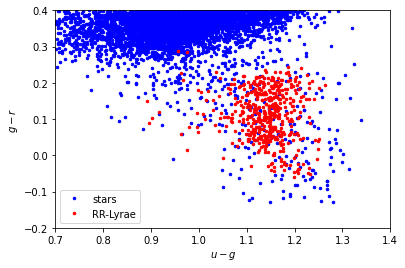

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import fetch_rrlyrae_combined

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()

X = X[-5000:]
y = y[-5000:]

stars = (y == 0)
rrlyrae = (y == 1)

#------------------------------------------------------------
# plot the results
ax = plt.axes()

ax.plot(X[stars, 0], X[stars, 1], '.', ms=5, c='b', label='stars')
ax.plot(X[rrlyrae, 0], X[rrlyrae, 1], '.', ms=5, c='r', label='RR-Lyrae')

ax.legend(loc=3)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

ax.set_xlim(0.7, 1.4)
ax.set_ylim(-0.2, 0.4)

plt.show()

---
# Exercise 1

In [2]:
_X, _y = fetch_rrlyrae_combined()

_X.shape, _y.sum()

((93141, 4), 483.0)

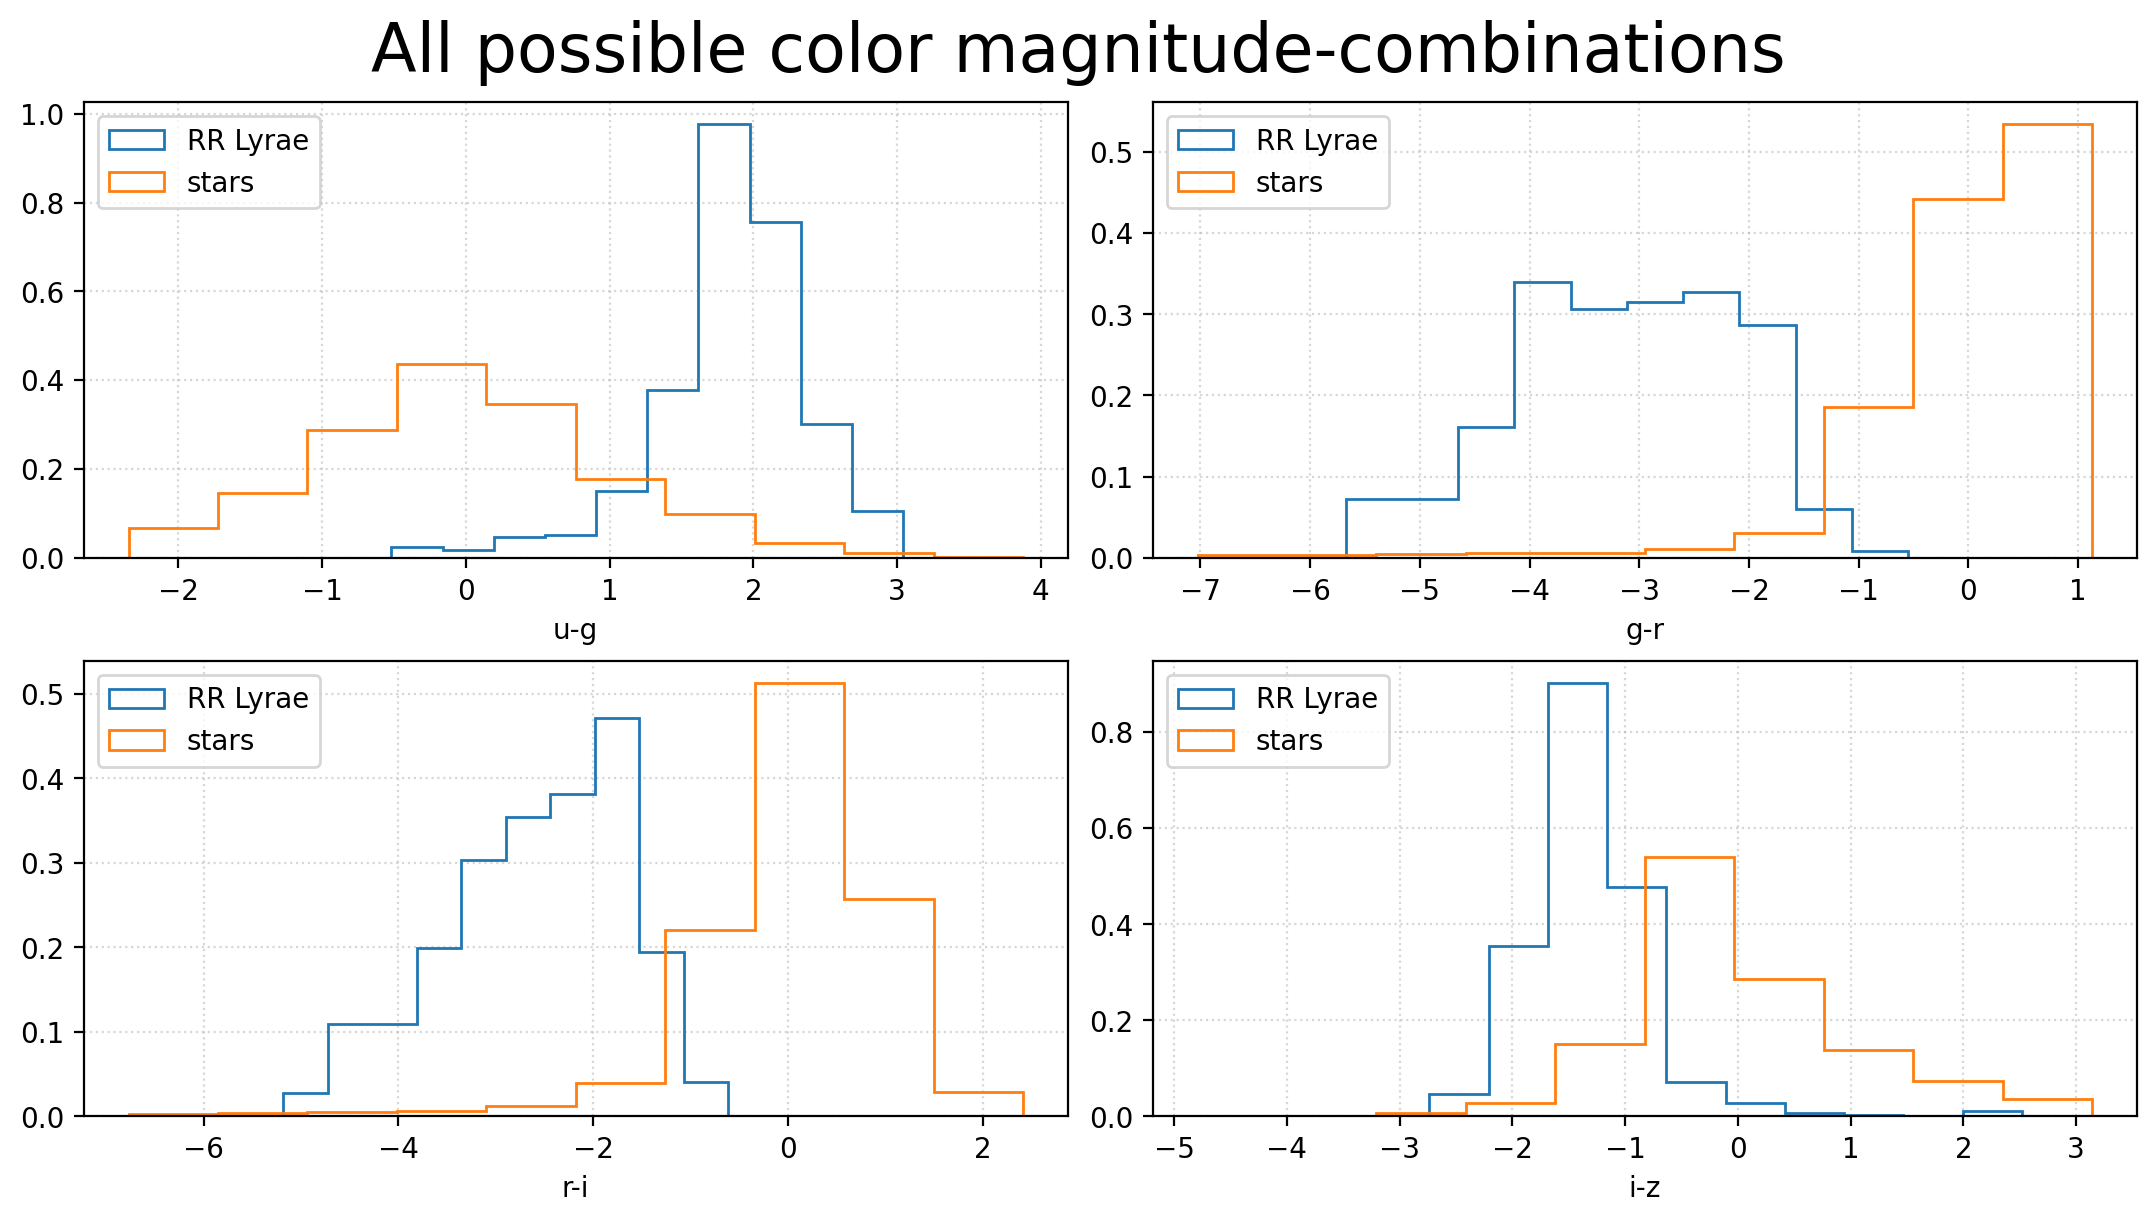

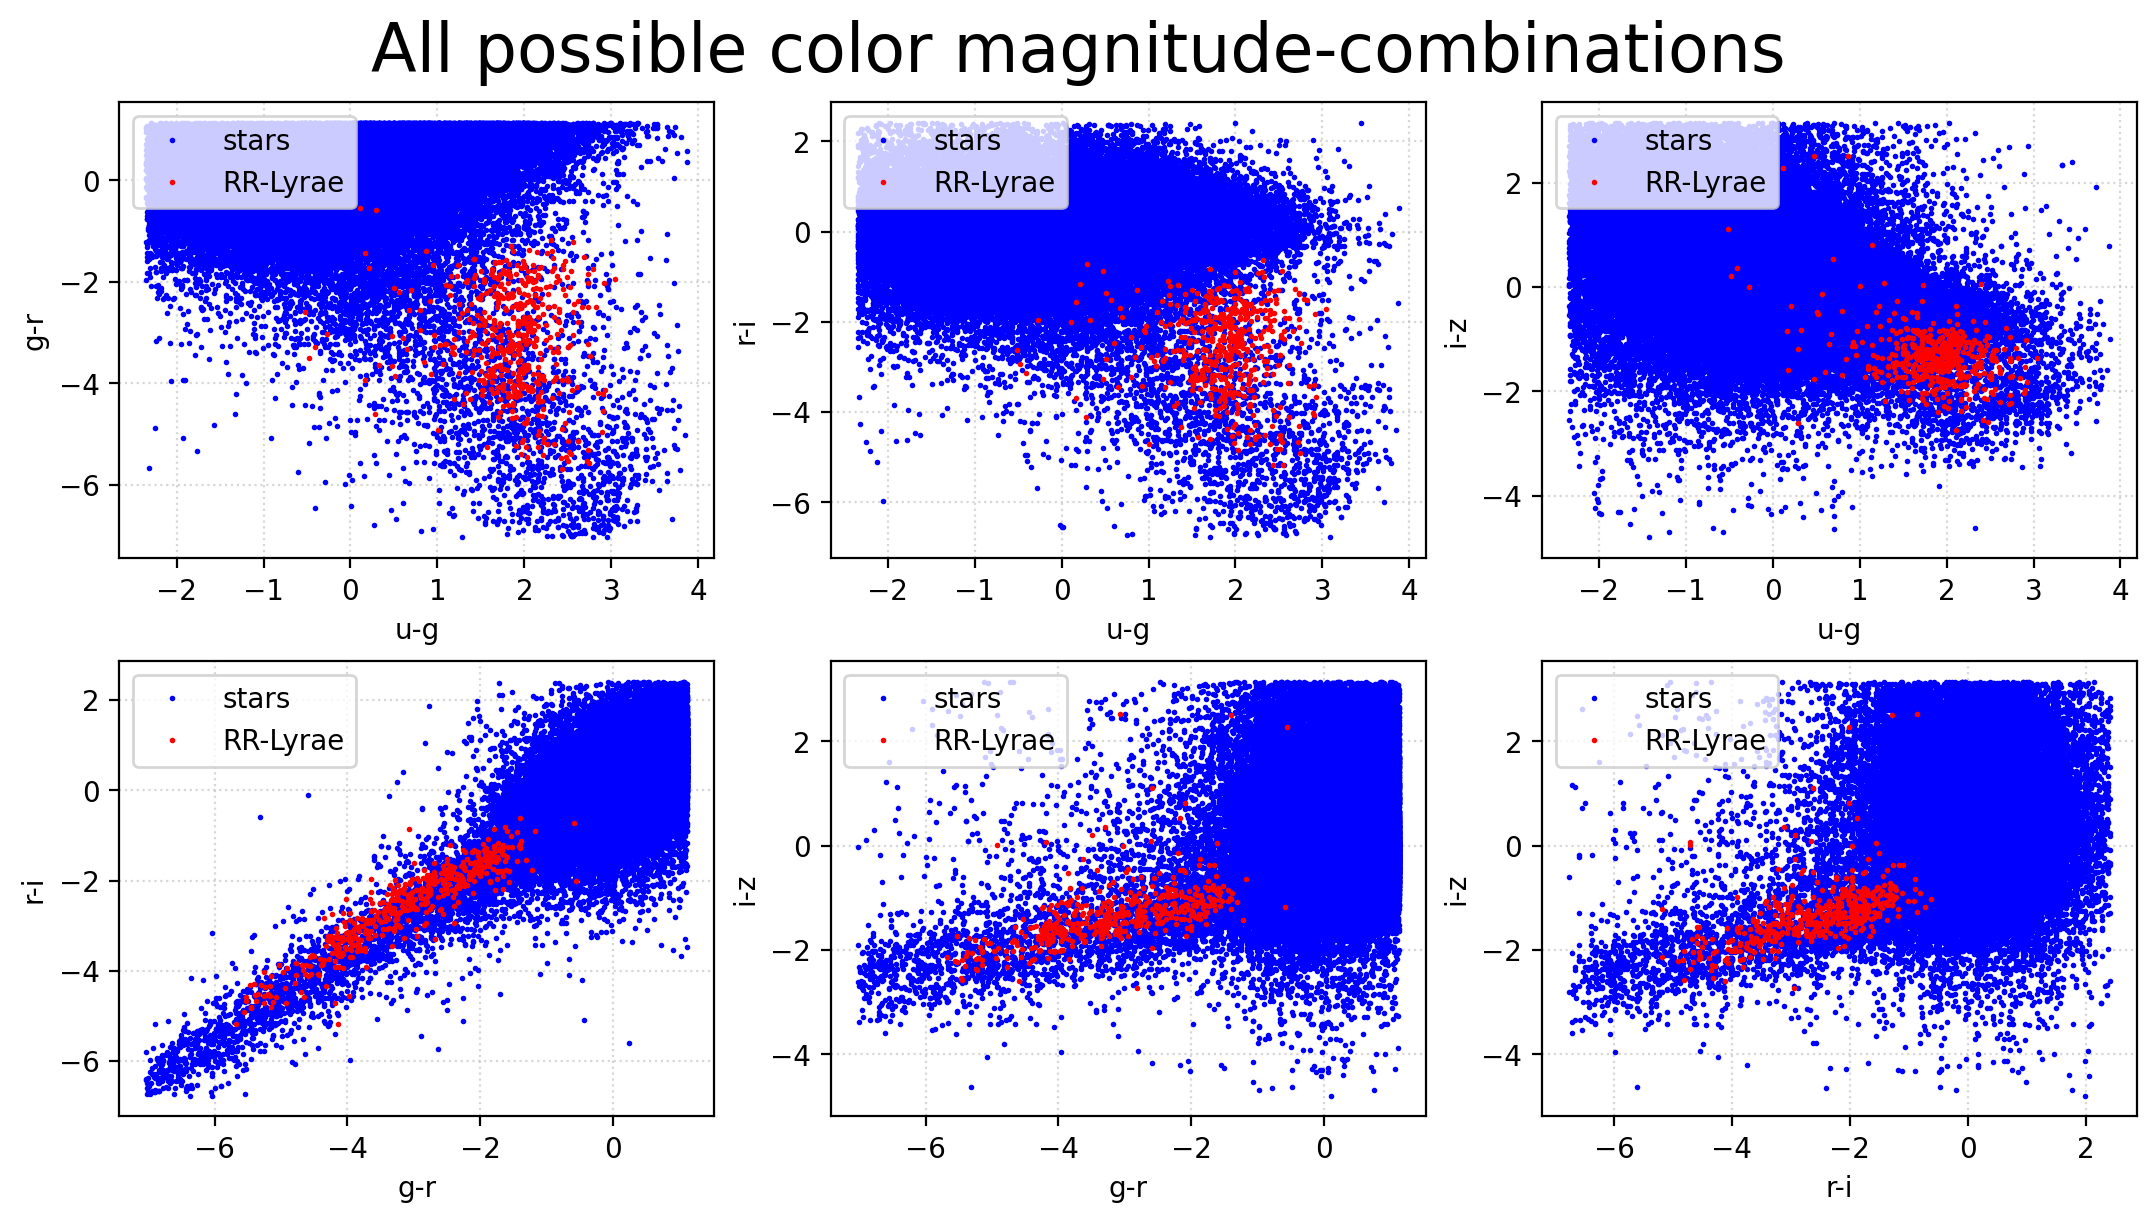

In [3]:
# names of the features, i. e. color magnitudes
features = "u-g g-r r-i i-z".split()

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()

all_mean = X.mean(axis=0)
all_std = X.std(axis=0)
# Manual Batch Normalization
X = (X - all_mean) / all_std

stars = (y == 0)
rrlyrae = (y == 1)

# make six subplots
fig, axes = plt.subplots(2, 2, 
                         figsize=(32/3,6), 
                         dpi=200, 
                        #  sharex="col", 
                        #  sharey="row"
                         constrained_layout=True)

axes = axes.flatten() # 1D array

# # set the spacing between subplots
# plt.subplots_adjust(wspace=0.2, 
#                     hspace=0.2)

ax_cnt = 0

for i in range(len(features)):
    # for j in range(i+1, len(features)):
    ax = axes[ax_cnt]
    # ax.plot(X[stars, i], X[stars, j], '.', ms=2, c='b', label='stars')
    # ax.plot(X[rrlyrae, i], X[rrlyrae, j], '.', ms=2, c='r', label='RR-Lyrae')

    ax.hist(X[rrlyrae, i], histtype="step", label="RR Lyrae", density=True)
    ax.hist(X[stars, i], histtype="step", label="stars", density=True)
    ax.set_xlabel(features[i])
    # ax.set_ylabel(features[j])

    ax.grid(alpha=.5, linestyle=":")
    ax.legend(loc="upper left")

    ax_cnt += 1
        
fig.suptitle("All possible color magnitude-combinations", fontsize=24)
plt.show()


# make six subplots
fig, axes = plt.subplots(2, 3, 
                         figsize=(32/3,6), 
                         dpi=200, 
                        #  sharex="col", 
                        #  sharey="row"
                         constrained_layout=True)

axes = axes.flatten() # 1D array

# # set the spacing between subplots
# plt.subplots_adjust(wspace=0.2, 
#                     hspace=0.2)

ax_cnt = 0

for i in range(len(features)):
    for j in range(i+1, len(features)):
        ax = axes[ax_cnt]
        ax.plot(X[stars, i], X[stars, j], '.', ms=2, c='b', label='stars')
        ax.plot(X[rrlyrae, i], X[rrlyrae, j], '.', ms=2, c='r', label='RR-Lyrae')

        ax.set_xlabel(features[i])
        ax.set_ylabel(features[j])

        ax.grid(alpha=.5, linestyle=":")
        ax.legend(loc="upper left")

        ax_cnt += 1
        
fig.suptitle("All possible color magnitude-combinations", fontsize=24)
plt.show()

---
# Exercise 2: Normalizing flow

##### Load packages

In [4]:
import os
import sys
import numpy as np
module_path = os.path.abspath(os.path.join('normalizing-flows/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data.plot_samples import plot_samples_2d
from data.visu_density import plot_heatmap_2d
from data.dataset_loader import load_and_preprocess_uci
from normalizingflows.flow_catalog import NeuralSplineFlow
from utils.train_utils import train_density_no_tf, train_density_estimation, shuffle_split
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
import time
from utils.train_utils import sanity_check

/Users/lenny/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensorflow:  2.4.1
tensorflow-probability:  0.12.2


## Prepare data

In [5]:
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
#----------------------------------

# put them into one array
DATA = np.concatenate((X, y.reshape(y.size, 1)), axis=1)

# maxima/minima of the 4 color magnitudes
maxes = np.max(X, axis=0)
mins = np.min(X, axis=0)

# "up rounded" absolute extrema of all 4 color mag.s
# for [-B, B], see [Durkan et al.]
intervals = np.ceil(np.maximum(np.absolute(maxes), np.absolute(mins)))  

# train, val, test; preserves tensor shape WITH BOTH STARS AND RRLYRAE
data_train_all, data_validate_all, data_test_all = shuffle_split(DATA, TRAIN_SPLIT, VAL_SPLIT, seed=194297) 

# for the CLASSIFIER in ex. 3
test_data = data_test_all

2022-09-01 10:48:03.168228: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-01 10:48:03.168672: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## RR Lyrae

### Fetch the data and the related specifications [L. Rinder]

In [6]:
DATASET = "rrlyrae_lay_16"
BATCH_SIZE = 100
#----------------------------------
# below follows mostly copy+paste from L. Rinder, dataset_loader.py
#-----------------------------------

# masks for the rrlyrae
mask_train = data_train_all[:, 4] == 1
mask_validate = data_validate_all[:, 4] == 1
mask_test = data_test_all[:, 4] == 1

data_train = data_train_all[mask_train][:, :4]
data_validate = data_validate_all[mask_validate][:, :4]
data_test = data_test_all[mask_test][:, :4]

# slice into list-like objects, shape (4,)
data_train = tf.data.Dataset.from_tensor_slices(data_train)
data_validate = tf.data.Dataset.from_tensor_slices(data_validate)
data_test = tf.data.Dataset.from_tensor_slices(data_test)

# combine elements into batches, shape (None, 4)
batched_train_data = data_train.batch(BATCH_SIZE)
batched_val_data = data_validate.batch(BATCH_SIZE)
batched_test_data = data_test.batch(BATCH_SIZE)

# extract the shape of the input data,
# we know it's 4, but for generality:
sample_batch = next(iter(batched_train_data))
input_shape = int(sample_batch.shape[1])

### Architecture [L. Rinder]

In [7]:
# layers of bijectors
LAYERS = 16
# bins in the spline, Durkan et al.
N_BINS = 8
#----------------------------------

# cast array [2, 3, 0, 1] to a tensor 
permutation = tf.cast(np.concatenate((np.arange(input_shape/2,input_shape), 
                                      np.arange(0,input_shape/2)))
                      , tf.int32)

# 4-dim. standard normal
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros(input_shape, tf.float32)) 

bijector_chain = []
for i in range(LAYERS):
    
    # using the NSF implemented by Rinder, based on Durkan et al.,
    # d_dim: trainable params (eqs. 9-11 in Durkan et al.), 
    # we choose half of the input-dim.
    bijector_chain.append(NeuralSplineFlow(input_dim=input_shape, 
                                           d_dim=int(input_shape/2)+1, 
                                           number_of_bins=N_BINS, 
                                           b_interval=intervals))
    
    # permute to ensure all variables can interact
    bijector_chain.append(tfp.bijectors.Permute(permutation))

# chain them together, in reverse
# result: just another Bijector
bijector = tfb.Chain(bijectors=list(reversed(bijector_chain)), name='chain_of_real_nvp')

# the final flow with:
#     * the 4-dim. standard normal as the base/target distribution
#     * the bijector-chain as the transformation
flow_rrlyrae = tfd.TransformedDistribution(distribution=base_dist,
                                   bijector=bijector)


# number of trainable variables
n_trainable_variables = flow_rrlyrae.trainable_variables
# len(n_trainable_variables)

len(n_trainable_variables)

2022-09-01 10:48:03.394566: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


96

### Training [L. Rinder]

#### Initializing:

In [8]:
SHAPE = [256, 256]
BASE_LR = 0.005
MAX_EPOCHS = 1000
# stop-cond. if too far from minimum
DELTA_COUNT = 15
# ---------------------------------

checkpoint_directory = "{}/tmp_{}_{}_{}".format(DATASET, LAYERS, SHAPE[0], BASE_LR)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=BASE_LR)
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=flow_rrlyrae)

global_step = []
train_losses = []
val_losses = []

# high value to ensure that first loss < min_loss
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
# threshold for early stopping
delta = 0

# start time
t_start = time.time()

#### Start to train:

In [9]:
for i in range(MAX_EPOCHS):
    # training of batches, one whole loop corresponds to all train_data 
    for batch in batched_train_data:
        train_loss = train_density_no_tf(flow_rrlyrae, optimizer, batch)

    if i % int(10) == 0:
        batch_val_losses = []
        for batch in batched_val_data:
            batch_loss = -tf.reduce_mean(flow_rrlyrae.log_prob(batch))
            batch_val_losses.append(batch_loss)
        val_loss = tf.reduce_mean(batch_val_losses)
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i

            checkpoint.write(file_prefix=checkpoint_prefix)

        elif i - min_val_epoch > DELTA_COUNT:
            break

train_time = time.time() - t_start

print(f"Train time: {train_time//3600:.0f}:{(train_time//60) % 60:.0f}:{train_time%60:.0f} h")

0, train_loss: 8.026985168457031, val_loss: 10.113174438476562
10, train_loss: 3.1533920764923096, val_loss: 4.552554130554199
20, train_loss: 2.306523323059082, val_loss: 4.302428245544434
30, train_loss: 2.3569493293762207, val_loss: 4.197891712188721
40, train_loss: 2.246277093887329, val_loss: 4.181276321411133
50, train_loss: 1.971954107284546, val_loss: 4.099837779998779
60, train_loss: 1.8507301807403564, val_loss: 4.423762321472168
70, train_loss: 1.7110618352890015, val_loss: 4.422930717468262
Train time: 0:2:27 h


### Evaluation

In [10]:
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
t_start = time.time()
test_losses = []
for batch in batched_test_data:
    batch_loss = -tf.reduce_mean(flow_rrlyrae.log_prob(batch))
    test_losses.append(batch_loss)

test_loss = tf.reduce_mean(test_losses)

        
test_time = time.time() - t_start

print(f"Test time: {test_time//3600:.0f}:{(test_time//60) % 60:.0f}:{test_time%60:.3f} h")

Test time: 0:0:0.214 h


#### Plot the distribution, 2 coordinates fixed to 0

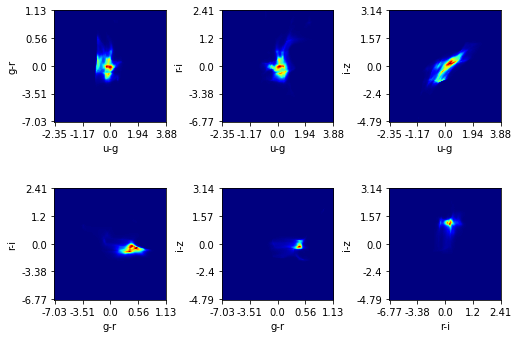

In [11]:
# save density estimation of best model
save_dir = "{}/{}_density_{}_{}_{}_{}_{}".format(DATASET, DATASET, BATCH_SIZE, LAYERS, SHAPE, BASE_LR, min_val_epoch)
b_max = intervals.max()
dist = flow_rrlyrae

#--------------------------------------------------------------------
# COORDINATE MESH

mesh_count = 101

x1 = tf.linspace(mins[0], maxes[0], mesh_count)
x2 = tf.linspace(mins[1], maxes[1], mesh_count)
x3 = tf.linspace(mins[2], maxes[2], mesh_count)
x4 = tf.linspace(mins[3], maxes[3], mesh_count)

X1, X2, X3, X4 = tf.meshgrid(x1, x2, x3, x4)

mesh_coordinates = tf.transpose(tf.stack([tf.reshape(X1, [-1]), tf.reshape(X2, [-1]), tf.reshape(X3, [-1]), tf.reshape(X4, [-1])]))

mesh_coordinates = tf.cast(mesh_coordinates, tf.float32)

#--------------------------------------------------------------------
# PLOTTING

fig, axes = plt.subplots(2, 3, figsize=(8,6))
plt.subplots_adjust(wspace=0.5, hspace=0.2)

ax_cnt = 0

for i in range(4):
    for j in range(i+1, 4):
        # mesh for only two variables letting the rest constant
        mean_i = np.median(mesh_coordinates[:, i].numpy())
        mean_j = np.median(mesh_coordinates[:, j].numpy())

        # mask_mesh = (mesh_coordinates[:, 1].numpy() == mean1) * (mesh_coordinates[:, 2].numpy() == mean2)
        # use np.isclose because float1 == float2 is ambigous
        mask_mesh = np.isclose(mesh_coordinates[:, i].numpy(), mean_i) * np.isclose(mesh_coordinates[:, j].numpy(), mean_j)

        mesh_ij = mesh_coordinates[mask_mesh]

        prob = dist.prob(mesh_ij)

        #plt.hexbin(concatenated_mesh_coordinates[:,0], concatenated_mesh_coordinates[:,1], C=prob, cmap='rainbow')
        # prob = prob.numpy()
        
        ax = axes.flatten()[ax_cnt]

        ax.imshow(tf.transpose(tf.reshape(prob, (mesh_count, mesh_count))), origin="lower", cmap=plt.cm.jet)
        ax.set_xticks([0, mesh_count * 0.25, mesh_count * 0.5, mesh_count * 0.75, mesh_count], np.round([mins[i], mins[i]/2, 0, maxes[i]/2, maxes[i]], 2))
        ax.set_yticks([0, mesh_count * 0.25, mesh_count * 0.5, mesh_count * 0.75, mesh_count], np.round([mins[j], mins[j]/2, 0, maxes[j]/2, maxes[j]], 2))
        
        ax.set_xlabel(features[i])
        ax.set_ylabel(features[j])
        
        ax_cnt += 1
        
# plt.savefig(name + ".png", format="png")  
# plot_heatmap_2d(flow, -heatmap_range, heatmap_range, -heatmap_range, heatmap_range, name=save_dir)

#### Print losses

Test loss: 3.3979885578155518 at epoch: 3
Min val loss: 4.099837779998779 at epoch: 50
Last val loss: 4.422930717468262 at epoch: 3
Min train loss: 1.7110618352890015 at epoch: 70
Last val loss: 1.7110618352890015 at epoch: 3
Training time: 147.03151106834412
Test time: 0.2142171859741211


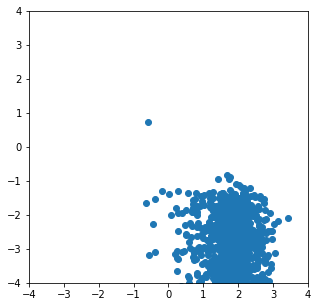

In [12]:
save_dir = "{}/{}_sampling_{}_{}_{}_{}_{}".format(DATASET, DATASET, BATCH_SIZE, LAYERS, SHAPE, BASE_LR, min_val_epoch)
plot_samples_2d(flow_rrlyrae.sample(1000), name=save_dir)

# remove checkpoint
filelist = [f for f in os.listdir(checkpoint_directory)]
for f in filelist:
    os.remove(os.path.join(checkpoint_directory, f))
os.removedirs(checkpoint_directory)

print(f'Test loss: {test_loss} at epoch: {i}')
print(f'Min val loss: {min_val_loss} at epoch: {min_val_epoch}')
print(f'Last val loss: {val_loss} at epoch: {i}')
print(f'Min train loss: {min_train_loss} at epoch: {min_train_epoch}')
print(f'Last val loss: {train_loss} at epoch: {i}')
print(f'Training time: {train_time}')
print(f'Test time: {test_time}')

results = {
    'test_loss': float(test_loss),
    'min_val_loss': float(min_val_loss),
    'min_val_epoch': min_val_epoch,
    'val_loss': float(val_loss),
    'min_train_loss': float(min_train_loss),
    'min_train_epoch': min_train_epoch,
    'train_loss': float(train_loss),
    'train_time': train_time,
    'test_time': test_time,
    'trained_epochs': i,
    'trainable variables': n_trainable_variables,
}

In [13]:
# save_dir = "{}/{}_sampling_{}_{}_{}_{}_{}".format(DATASET, DATASET, BATCH_SIZE, LAYERS, SHAPE, BASE_LR, min_val_epoch)
# plot_samples_2d(flow.sample(1000), name=save_dir)

# # remove checkpoint
# filelist = [f for f in os.listdir(checkpoint_directory)]
# for f in filelist:
#     os.remove(os.path.join(checkpoint_directory, f))
# os.removedirs(checkpoint_directory)

# print(f'Test loss: {test_loss} at epoch: {i}')
# print(f'Min val loss: {min_val_loss} at epoch: {min_val_epoch}')
# print(f'Last val loss: {val_loss} at epoch: {i}')
# print(f'Min train loss: {min_train_loss} at epoch: {min_train_epoch}')
# print(f'Last val loss: {train_loss} at epoch: {i}')
# print(f'Training time: {train_time}')
# print(f'Test time: {test_time}')

# results = {
#     'test_loss': float(test_loss),
#     'min_val_loss': float(min_val_loss),
#     'min_val_epoch': min_val_epoch,
#     'val_loss': float(val_loss),
#     'min_train_loss': float(min_train_loss),
#     'min_train_epoch': min_train_epoch,
#     'train_loss': float(train_loss),
#     'train_time': train_time,
#     'test_time': test_time,
#     'trained_epochs': i,
#     'trainable variables': n_trainable_variables,
# }

## Stars

### Fetch the data and the related specifications [L. Rinder]

In [14]:
DATASET = "stars_lay_16"
BATCH_SIZE = 1000
#----------------------------------
# below follows mostly copy+paste from L. Rinder, dataset_loader.py
#-----------------------------------

# masks for the stars
mask_train = data_train_all[:, 4] == 0
mask_validate = data_validate_all[:, 4] == 0
mask_test = data_test_all[:, 4] == 0

data_train = data_train_all[mask_train][:, :4]
data_validate = data_validate_all[mask_validate][:, :4]
data_test = data_test_all[mask_test][:, :4]

# slice into list-like objects, shape (4,)
data_train = tf.data.Dataset.from_tensor_slices(data_train)
data_validate = tf.data.Dataset.from_tensor_slices(data_validate)
data_test = tf.data.Dataset.from_tensor_slices(data_test)

# combine elements into batches, shape (None, 4)
batched_train_data = data_train.batch(BATCH_SIZE)
batched_val_data = data_validate.batch(BATCH_SIZE)
batched_test_data = data_test.batch(BATCH_SIZE)

# extract the shape of the input data,
# we know it's 4, but for generality:
sample_batch = next(iter(batched_train_data))
input_shape = int(sample_batch.shape[1])

### Architecture [L. Rinder]

In [15]:
# layers of bijectors
LAYERS = 16
# bins in the spline, Durkan et al.
N_BINS = 8
#----------------------------------

# cast array [2, 3, 0, 1] to a tensor 
permutation = tf.cast(np.concatenate((np.arange(input_shape/2,input_shape), 
                                      np.arange(0,input_shape/2)))
                      , tf.int32)

# 4-dim. standard normal
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros(input_shape, tf.float32)) 

bijector_chain = []
for i in range(LAYERS):
    
    # using the NSF implemented by Rinder, based on Durkan et al.,
    # d_dim: trainable params (eqs. 9-11 in Durkan et al.), 
    # we choose half of the input-dim.
    bijector_chain.append(NeuralSplineFlow(input_dim=input_shape, 
                                           d_dim=int(input_shape/2)+1, 
                                           number_of_bins=N_BINS, 
                                           b_interval=intervals))
    
    # permute to ensure all variables can interact
    bijector_chain.append(tfp.bijectors.Permute(permutation))

# chain them together, in reverse
bijector = tfb.Chain(bijectors=list(reversed(bijector_chain)), name='chain_of_real_nvp')

# the final flow with:
#     * the 4-dim. standard normal as the base/target distribution
#     * the bijector-chain as the transformation

flow_stars = tfd.TransformedDistribution(distribution=base_dist,
                                   bijector=bijector)


# number of trainable variables
n_trainable_variables = flow_stars.trainable_variables
# len(n_trainable_variables)

len(n_trainable_variables)

96

### Training [L. Rinder]

##### Initializing:

In [16]:
SHAPE = [256, 256]
BASE_LR = 0.005
MAX_EPOCHS = 1000
# stop-cond. if too far from minimum
DELTA_COUNT = 15
# ---------------------------------

checkpoint_directory = "{}/tmp_{}_{}_{}".format(DATASET, LAYERS, SHAPE[0], BASE_LR)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=BASE_LR)
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=flow_stars)

global_step = []
train_losses = []
val_losses = []

# high value to ensure that first loss < min_loss
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
# threshold for early stopping
delta = 0

# start time
t_start = time.time()

##### Start to train:

In [17]:
for i in range(MAX_EPOCHS):
    # training of batches, one whole loop corresponds to all train_data 
    for batch in batched_train_data:
        train_loss = train_density_no_tf(flow_stars, optimizer, batch)

    if i % int(10) == 0:
        batch_val_losses = []
        for batch in batched_val_data:
            batch_loss = -tf.reduce_mean(flow_stars.log_prob(batch))
            batch_val_losses.append(batch_loss)
        val_loss = tf.reduce_mean(batch_val_losses)
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i

            checkpoint.write(file_prefix=checkpoint_prefix)

        elif i - min_val_epoch > DELTA_COUNT:
            break

train_time = time.time() - t_start

print(f"Train time: {train_time//3600:.0f}:{(train_time//60) % 60:.0f}:{train_time%60:.0f} h")

0, train_loss: 4.122902870178223, val_loss: 4.424459457397461
10, train_loss: 3.9704980850219727, val_loss: 4.306565761566162
20, train_loss: 3.936929225921631, val_loss: 4.297527313232422
30, train_loss: 3.9171512126922607, val_loss: 4.283440113067627
40, train_loss: 3.9359512329101562, val_loss: 4.27868127822876
50, train_loss: 3.916902542114258, val_loss: 4.274924278259277
60, train_loss: 3.9063215255737305, val_loss: 4.2866716384887695
70, train_loss: 3.8957529067993164, val_loss: 4.304988384246826
Train time: 0:59:28 h


### Evaluation

In [18]:
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
t_start = time.time()
test_losses = []
for batch in batched_test_data:
    batch_loss = -tf.reduce_mean(flow_stars.log_prob(batch))
    test_losses.append(batch_loss)

test_loss = tf.reduce_mean(test_losses)

        
test_time = time.time() - t_start

print(f"Test time: {test_time//3600:.0f}:{(test_time//60) % 60:.0f}:{test_time%60:.3f} h")

Test time: 0:0:2.676 h


#### Plot the distribution, 2 coordinates fixed to 0

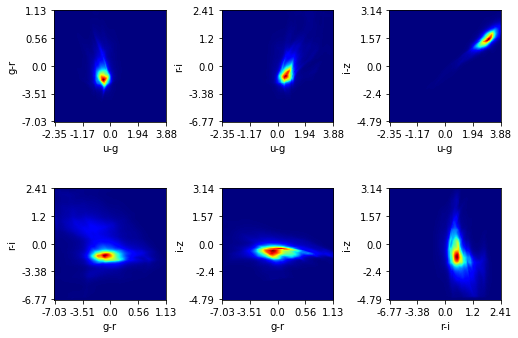

In [19]:
# save density estimation of best model
save_dir = "{}/{}_density_{}_{}_{}_{}_{}".format(DATASET, DATASET, BATCH_SIZE, LAYERS, SHAPE, BASE_LR, min_val_epoch)
b_max = intervals.max()
dist = flow_stars

#--------------------------------------------------------------------
# COORDINATE MESH

mesh_count = 101

x1 = tf.linspace(mins[0], maxes[0], mesh_count)
x2 = tf.linspace(mins[1], maxes[1], mesh_count)
x3 = tf.linspace(mins[2], maxes[2], mesh_count)
x4 = tf.linspace(mins[3], maxes[3], mesh_count)

X1, X2, X3, X4 = tf.meshgrid(x1, x2, x3, x4)

mesh_coordinates = tf.transpose(tf.stack([tf.reshape(X1, [-1]), tf.reshape(X2, [-1]), tf.reshape(X3, [-1]), tf.reshape(X4, [-1])]))

mesh_coordinates = tf.cast(mesh_coordinates, tf.float32)

#--------------------------------------------------------------------
# PLOTTING

fig, axes = plt.subplots(2, 3, figsize=(8,6))
plt.subplots_adjust(wspace=0.5, hspace=0.2)

ax_cnt = 0

for i in range(4):
    for j in range(i+1, 4):
        # mesh for only two variables letting the rest constant
        mean_i = np.median(mesh_coordinates[:, i].numpy())
        mean_j = np.median(mesh_coordinates[:, j].numpy())

        # mask_mesh = (mesh_coordinates[:, 1].numpy() == mean1) * (mesh_coordinates[:, 2].numpy() == mean2)
        # use np.isclose because float1 == float2 is ambigous
        mask_mesh = np.isclose(mesh_coordinates[:, i].numpy(), mean_i) * np.isclose(mesh_coordinates[:, j].numpy(), mean_j)

        mesh_ij = mesh_coordinates[mask_mesh]

        prob = dist.prob(mesh_ij)

        #plt.hexbin(concatenated_mesh_coordinates[:,0], concatenated_mesh_coordinates[:,1], C=prob, cmap='rainbow')
        # prob = prob.numpy()
        
        ax = axes.flatten()[ax_cnt]

        ax.imshow(tf.transpose(tf.reshape(prob, (mesh_count, mesh_count))), origin="lower", cmap=plt.cm.jet)
        ax.set_xticks([0, mesh_count * 0.25, mesh_count * 0.5, mesh_count * 0.75, mesh_count], np.round([mins[i], mins[i]/2, 0, maxes[i]/2, maxes[i]], 2))
        ax.set_yticks([0, mesh_count * 0.25, mesh_count * 0.5, mesh_count * 0.75, mesh_count], np.round([mins[j], mins[j]/2, 0, maxes[j]/2, maxes[j]], 2))
        
        ax.set_xlabel(features[i])
        ax.set_ylabel(features[j])
        
        ax_cnt += 1
        
# plt.savefig(name + ".png", format="png")  
# plot_heatmap_2d(flow, -heatmap_range, heatmap_range, -heatmap_range, heatmap_range, name=save_dir)

#### Print losses

Test loss: 4.292097568511963 at epoch: 3
Min val loss: 4.274924278259277 at epoch: 50
Last val loss: 4.304988384246826 at epoch: 3
Min train loss: 3.8957529067993164 at epoch: 70
Last val loss: 3.8957529067993164 at epoch: 3
Training time: 3568.3850791454315
Test time: 2.6755011081695557


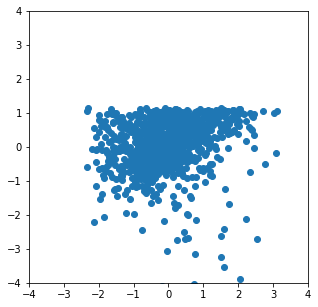

In [20]:
save_dir = "{}/{}_sampling_{}_{}_{}_{}_{}".format(DATASET, DATASET, BATCH_SIZE, LAYERS, SHAPE, BASE_LR, min_val_epoch)
plot_samples_2d(flow_stars.sample(1000), name=save_dir)

# remove checkpoint
filelist = [f for f in os.listdir(checkpoint_directory)]
for f in filelist:
    os.remove(os.path.join(checkpoint_directory, f))
os.removedirs(checkpoint_directory)

print(f'Test loss: {test_loss} at epoch: {i}')
print(f'Min val loss: {min_val_loss} at epoch: {min_val_epoch}')
print(f'Last val loss: {val_loss} at epoch: {i}')
print(f'Min train loss: {min_train_loss} at epoch: {min_train_epoch}')
print(f'Last val loss: {train_loss} at epoch: {i}')
print(f'Training time: {train_time}')
print(f'Test time: {test_time}')

results = {
    'test_loss': float(test_loss),
    'min_val_loss': float(min_val_loss),
    'min_val_epoch': min_val_epoch,
    'val_loss': float(val_loss),
    'min_train_loss': float(min_train_loss),
    'min_train_epoch': min_train_epoch,
    'train_loss': float(train_loss),
    'train_time': train_time,
    'test_time': test_time,
    'trained_epochs': i,
    'trainable variables': n_trainable_variables,
}

---
# Exercise 3: Classifier

### Define the classifier

In [44]:
class rrlyrae_classifier:
    def __init__(self, dist_rrlyrae, dist_stars):
        self.dist_rrlyrae = dist_rrlyrae
        self.dist_stars = dist_stars
        return None
    
    def get_test_data(self, test_data):
        """
        load the testdata array and the corresponding y (target, 0 or 1)
        """
        self.test_data = test_data[:, :4]
        self.y_true = test_data[:, 4].numpy()
        return None
    
    def predict(self, activation="tanh"):
        """
        evaluate the prediction
        
        :activation : {tanh, atan, logistic, erfc}:
        
        returns: y_score in range [0,1]
        """
        from scipy.special import erfc
        if activation=="tanh":
            afunc = lambda x: (np.tanh(2*x)+1)/2
        if activation=="atan":
            afunc = lambda x: 0.5+np.arctan(x)/np.pi
        if activation=="logistic":
            afunc = lambda x: 1/(1+np.exp(-x))
        if activation=="erfc":
            afunc = lambda x: erfc(-x)/2.

        # evaluate at given PDF, gives prob per input
        prob_stars = self.dist_stars.prob(self.test_data).numpy() + np.finfo(float).eps
        prob_rrlyrae = self.dist_rrlyrae.prob(self.test_data).numpy() + np.finfo(float).eps
        
        # log, to map them equally to (-inf, inf)
        log_prob = np.log10(prob_rrlyrae / prob_stars)
        
        # activation
        self.y_score = afunc(log_prob)
        
        return self.y_score
        
    def roc_curve(self, name=False, save=True):
        """
        plot a ROC curve of the classified data
        """
        from sklearn.metrics import roc_curve, roc_auc_score
        
        fpr, tpr, thresholds = roc_curve(self.y_true, self.y_score)
        auc = roc_auc_score(self.y_true, self.y_score) 
        plt.plot(fpr, tpr, color="navy")

        plt.title("ROC curve")
        plt.xlabel("purity")
        plt.ylabel("efficiency / error rate")

        plt.grid(alpha=.7, ls=":")
        if name:
            plt.savefig(name)
        
        if save:
            np.save(f"{DATASET}/fpr.npy", fpr)
            np.save(f"{DATASET}/tpr.npy", tpr)
            np.save(f"{DATASET}/auc.npy", auc)
            
        plt.show()
        
        return None
    
    def evaluate(self, thresh=0.5):
        N_test_data = self.y_true.size
        
        correct = ( (self.y_score > thresh) == (self.y_true > thresh) ).sum() / N_test_data
        fpr = ( (self.y_score > thresh) * (self.y_true < thresh) ).sum() / N_test_data
        fnr = ( (self.y_score < thresh) * (self.y_true > thresh) ).sum() / N_test_data
        tpr = ( (self.y_score > thresh) * (self.y_true > thresh) ).sum() / N_test_data
        tnr = ( (self.y_score < thresh) * (self.y_true < thresh) ).sum() / N_test_data

        pos_fraction = self.y_true.sum() / self.y_true.size
        neg_fraction = (1-self.y_true).sum() / self.y_true.size

        print("The Dataset:")
        print(f"Total percentage of positive/real RR Lyrae: \t {pos_fraction:.2%}")
        print(f"Total percentage of negative/not RR Lyrae: \t{neg_fraction:.2%} \n")

        print(f"Rate of predictions\n\t- correct: \t{correct:2.2%}")
        print(f"\t- false pos.: \t {fpr:2.2%}")
        print(f"\t- true pos.: \t {tpr:2.2%}")
        print(f"\t- false neg.: \t {fnr:2.2%}")
        print(f"\t- true neg.: \t{tnr:2.2%}\n")

        print(f"Percentage of correctly identified \n\t- RR Lyrae: \t{tpr/pos_fraction:.2%}")
        print(f"\t- non-RR Lyrae:\t{tnr/neg_fraction:.2%}")
        
        return None

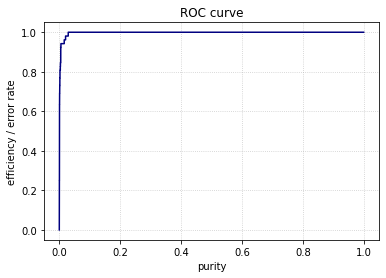

In [45]:
rrlyrae_clf = rrlyrae_classifier(flow_rrlyrae, flow_stars)

rrlyrae_clf.get_test_data(test_data)

prediction = rrlyrae_clf.predict()

rrlyrae_clf.roc_curve()

### Check the prediction

#### Choosing an activation function

--- 
Quick recap of some activation functions from exercise sheet 5:

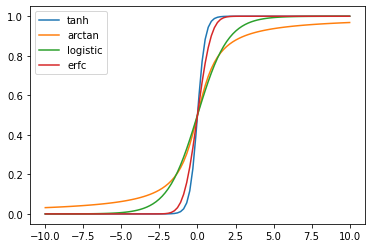

In [23]:
from scipy.special import erfc
x_values = np.linspace(-10, 10, 100)
plt.plot(x_values, (np.tanh(2*x_values)+1)/2, label = "tanh");
plt.plot(x_values, 0.5+np.arctan(x_values)/np.pi, label = "arctan");
plt.plot(x_values, 1/(1+np.exp(-x_values)), label = "logistic");
plt.plot(x_values, erfc(-x_values)/2., label = "erfc");
plt.legend();

---

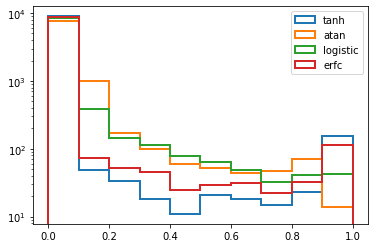

In [24]:
for afunc in "tanh atan logistic erfc".split():
    prediction = rrlyrae_clf.predict(activation=afunc)
    plt.hist(prediction, bins=10, histtype="step", label=afunc, lw=2, range=(0,1))
plt.yscale("log")
plt.legend()
plt.show()

I choose the `logistic` activation function, because it is more sensitive to rather equal probabilities of both flows:

In [25]:
prediction = rrlyrae_clf.predict(activation="logistic")

In [26]:
# dataset = "rrlyrae"
# samples = rrlyrae
# layers = 4 # these are the number of layers that normalizing flows changes the function to get to the gaussian
# shape = [16, 16] # whereas this shape represents the layers for determining the parameters of each of the function in each layer.
# delta_count = 15
# train_split = 0.8
# val_split = 0.1

# maxes = np.max(samples, axis=0)
# mins = np.min(samples, axis=0)
# intervals = np.ceil(np.maximum(np.absolute(maxes), np.absolute(mins))) 


# train_data, val_data, test_data = shuffle_split(samples, train_split, val_split)

#### Evaluating the prediction

I start by naively choosing the classification threshold to be at `0.5`:

In [27]:
rrlyrae_clf.evaluate()

The Dataset:
Total percentage of positive/real RR Lyrae: 	 0.56%
Total percentage of negative/not RR Lyrae: 	99.44% 

Rate of predictions
	- correct: 	98.06%
	- false pos.: 	 1.92%
	- true pos.: 	 0.54%
	- false neg.: 	 0.02%
	- true neg.: 	97.52%

Percentage of correctly identified 
	- RR Lyrae: 	96.15%
	- non-RR Lyrae:	98.07%


---
##### Fine-tuning the threshold

If a ___generally good___ classifier is wanted, then we need to maximize the correct predictions wrt. the threshold (or even the activation function):

In [28]:
max_correct, max_correct_thresh = 0., 0.
percentage_rrlyrae = test_data[:, 4].numpy().sum()/ test_data[:, 4].numpy().size
for thresh in np.linspace(0, 1-1e-4, 10000):
    correct = ( (prediction > thresh) == (test_data[:, 4].numpy() > thresh) ).sum() / prediction.size
    fnr = ( (prediction < thresh) * (test_data[:, 4].numpy() > thresh) ).sum() / prediction.size
    if correct > max_correct and fnr < percentage_rrlyrae:
        max_correct = correct
        max_correct_thresh = thresh
max_correct_thresh

0.8936000000000001

I found by numerically trying $10000$ thresholds in the range $[0, 0.9999]$ the maximum rate of correct classifications to be:

In [29]:
rrlyrae_clf.evaluate(thresh=max_correct_thresh)

The Dataset:
Total percentage of positive/real RR Lyrae: 	 0.56%
Total percentage of negative/not RR Lyrae: 	99.44% 

Rate of predictions
	- correct: 	99.72%
	- false pos.: 	 0.11%
	- true pos.: 	 0.39%
	- false neg.: 	 0.17%
	- true neg.: 	99.33%

Percentage of correctly identified 
	- RR Lyrae: 	69.23%
	- non-RR Lyrae:	99.89%


---
If on the other hand a ***clean classification*** of RR Lyrae is preferred, one needs to minimize the false-positive rate `fpr` with the condition that the true-positive rate `tpr` is larger than $0$:

In [30]:
min_fpr, min_fpr_thresh, min_ratio = 2., 2., 0.
for thresh in np.linspace(1e-4, 1, 10000):
    fpr = ( (prediction > thresh) * (test_data[:, 4].numpy() < thresh) ).sum() / prediction.size
    tpr = ( (prediction > thresh) * (test_data[:, 4].numpy() > thresh) ).sum() / prediction.size
    ratio = tpr/(fpr+1e-10)
    
    if ratio >= min_ratio:
        min_ratio = ratio
        min_fpr_thresh = thresh
min_fpr_thresh

0.9644

We find the threshold for the lowest `fpr` with a non-zero `tpr` and use it to get some statistics below:

In [31]:
rrlyrae_clf.evaluate(thresh=min_fpr_thresh)

The Dataset:
Total percentage of positive/real RR Lyrae: 	 0.56%
Total percentage of negative/not RR Lyrae: 	99.44% 

Rate of predictions
	- correct: 	99.51%
	- false pos.: 	 0.00%
	- true pos.: 	 0.06%
	- false neg.: 	 0.49%
	- true neg.: 	99.44%

Percentage of correctly identified 
	- RR Lyrae: 	11.54%
	- non-RR Lyrae:	100.00%


The `fpr` is *zero!* The `tpr` is 0.09 %, which means that **one of six** RR Lyrae is found! All found RR Lyrae are actually RR Lyrae.

---
# Testing the results

##### Samples + some real data:

In [32]:
# names of the features, i. e. color magnitudes
features = "u-g g-r r-i i-z".split()

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()

# X = X[-5000:]
# y = y[-5000:]

stars = (y == 0)
rrlyrae = (y == 1)

# guarantee to have the same proportion of rrlyrae to stars:
smp_stars = flow_stars.sample(sample_shape=(stars.sum())).numpy()
smp_rrlyrae = flow_rrlyrae.sample(sample_shape=(rrlyrae.sum())).numpy()

# reverse the initial manual BatchNorm
smp_stars = (smp_stars * all_std) + all_mean
smp_rrlyrae = (smp_rrlyrae * all_std) + all_mean

##### Histograms:

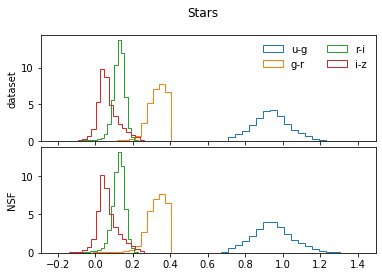

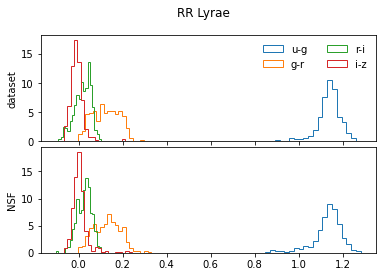

<Figure size 432x288 with 0 Axes>

In [33]:
fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=.05)

for i in range(4):
    hist_range = (smp_stars[:, i].min(), smp_stars[:, i].max())
    _ = ax1.hist(smp_stars[:, i], bins=20, histtype="step", label=features[i], density=True, range=hist_range)
    _ = ax2.hist(X[:, i][y == 0], bins=20, histtype="step", label=features[i], density=True, range=hist_range)
    # _ = ax1.hist(smp_stars[:, i], bins=20, histtype="step", range=(X.min(), X.max()), label=features[i],
    #             density=True)
    # _ = ax2.hist(X[:, i][y == 0], bins=20, histtype="step", range=(X.min(), X.max()), label=features[i],
    #             density=True)
    
ax2.legend(loc="best", ncol=2, frameon=False)
ax1.set_ylabel("NSF")
ax2.set_ylabel("dataset")
plt.suptitle("Stars")

plt.show()

fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=.05)

for i in range(4):
    hist_range = (smp_rrlyrae[:, i].min(), smp_rrlyrae[:, i].max())
    _ = ax1.hist(smp_rrlyrae[:, i], bins=20, histtype="step", label=features[i], density=True, range=hist_range)
    _ = ax2.hist(X[:, i][y == 1], bins=20, histtype="step", label=features[i], density=True, range=hist_range)
    # _ = ax1.hist(smp_rrlyrae[:, i], bins=20, histtype="step", range=(X.min(), X.max()), label=features[i],
    #             density=True)
    # _ = ax2.hist(X[:, i][y == 1], bins=20, histtype="step", range=(X.min(), X.max()), label=features[i],
    #             density=True)
    
ax2.legend(loc="best", ncol=2, frameon=False)
ax1.set_ylabel("NSF")
ax2.set_ylabel("dataset")
plt.suptitle("RR Lyrae")

plt.show()
plt.savefig("figs/sample_hists/best-Layers_64.pdf")

##### Scatter plots

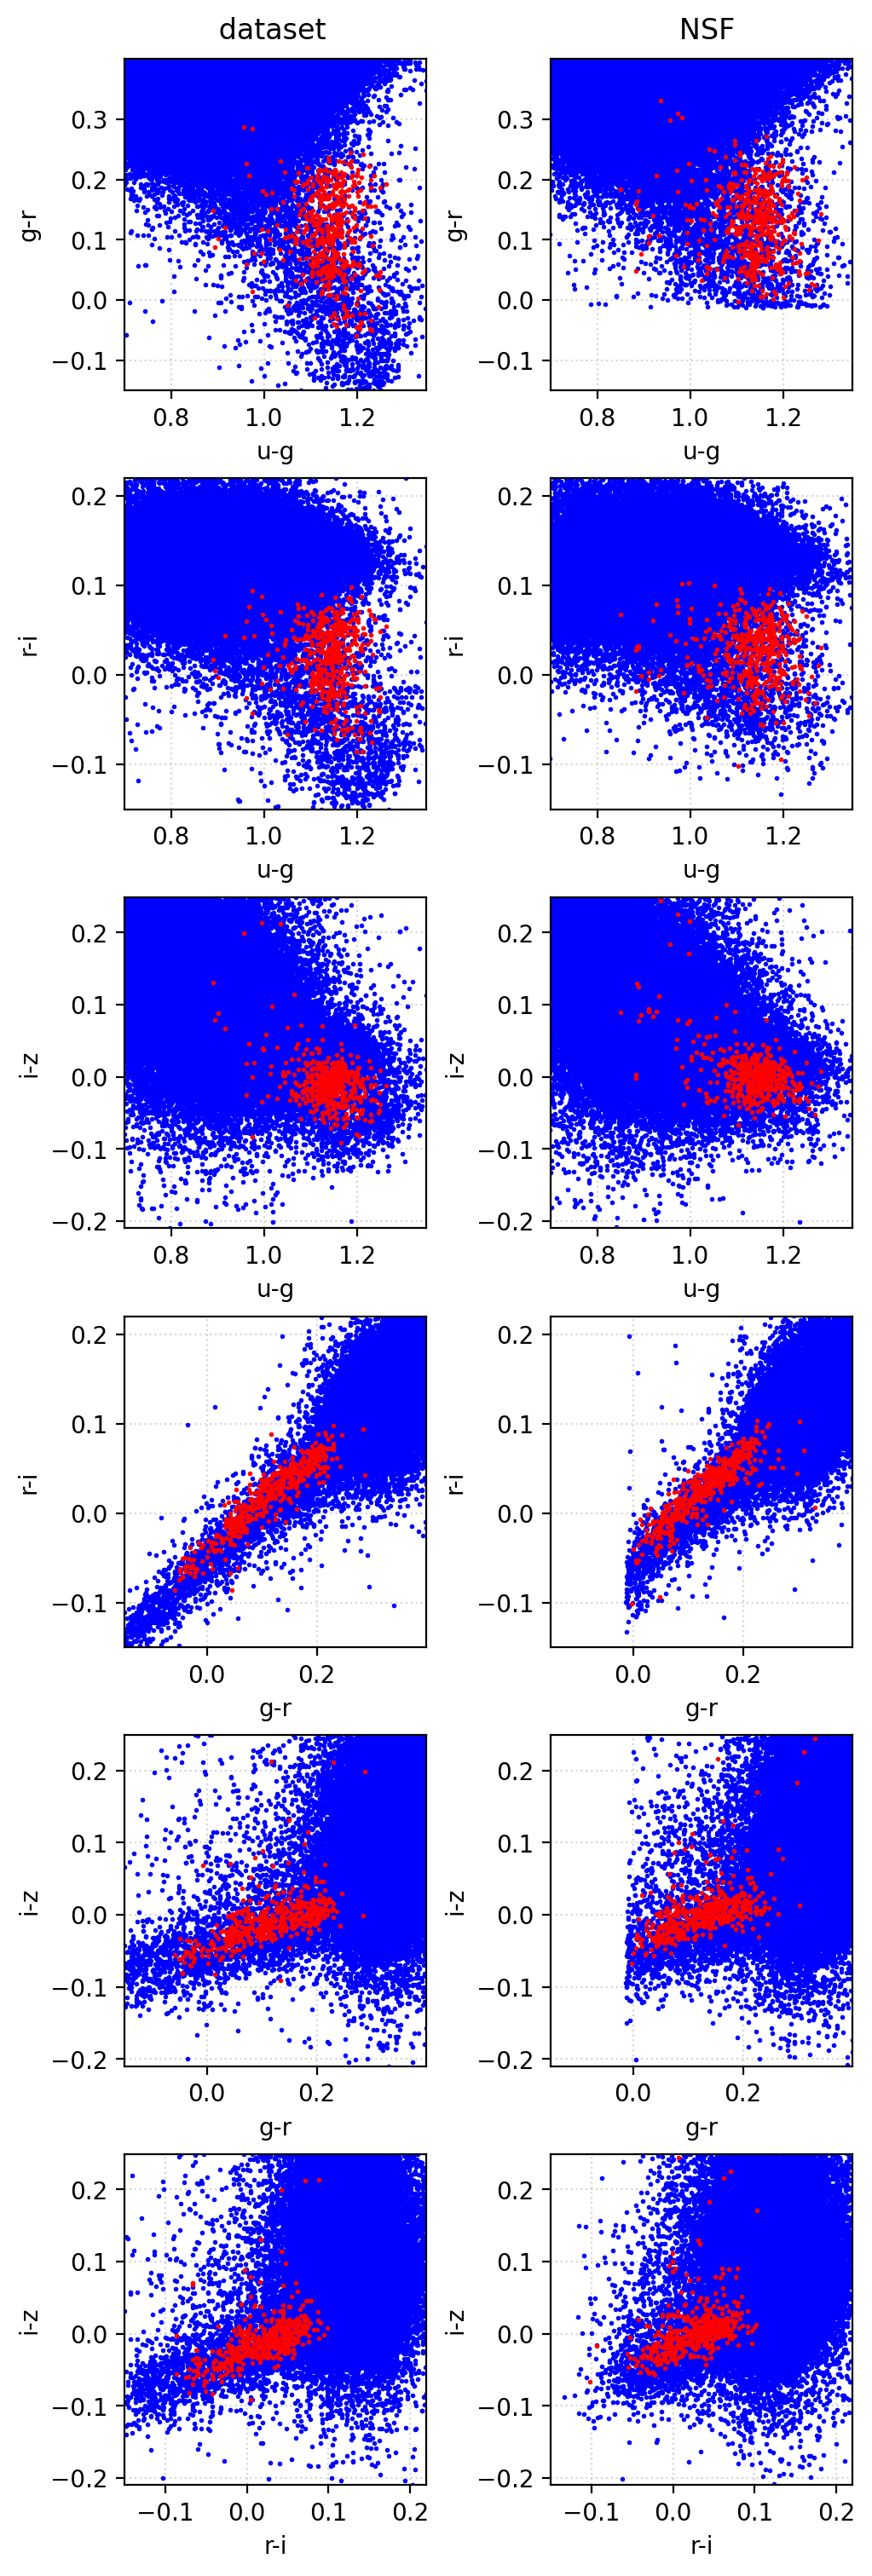

In [34]:
# names of the features, i. e. color magnitudes
features = "u-g g-r r-i i-z".split()

#----------------------------------------------------------------------
# # get data and split into training & testing sets
# X, y = fetch_rrlyrae_combined()

# X = X[-5000:]
# y = y[-5000:]

# stars = (y == 0)
# rrlyrae = (y == 1)

# make six subplots
fig, axes = plt.subplots(6, 2, 
                         figsize=(5,15), 
                         dpi=200, 
                         # sharex="row", 
                         # sharey="row",
                         constrained_layout=True)

axes = axes.flatten() # 1D array

# # set the spacing between subplots
# plt.subplots_adjust(wspace=0.2, 
#                     hspace=0.2)

ax_cnt = 0

for i in range(len(features)):
    for j in range(i+1, len(features)):
        # REAL
        
        ax = axes[ax_cnt]
        ax.plot(X[stars, i], X[stars, j], '.', ms=2, c='b', label='stars')
        ax.plot(X[rrlyrae, i], X[rrlyrae, j], '.', ms=2, c='r', label='RR-Lyrae')

        ax.set_xlabel(features[i])
        ax.set_ylabel(features[j])
        
        ax.set_xlim(X[:, i].min(), X[:, i].max())
        ax.set_ylim(X[:, j].min(), X[:, j].max())

        ax.grid(alpha=.5, linestyle=":")
        # ax.legend(loc="upper left")

        ax_cnt += 1
        
        # SAMPLE
        
        ax = axes[ax_cnt]
        ax.plot(smp_stars[:, i], smp_stars[:, j], '.', ms=2, c='b', label='stars')
        ax.plot(smp_rrlyrae[:, i], smp_rrlyrae[:, j], '.', ms=2, c='r', label='RR-Lyrae')

        ax.set_xlabel(features[i])
        ax.set_ylabel(features[j])
        
        ax.set_xlim(X[:, i].min(), X[:, i].max())
        ax.set_ylim(X[:, j].min(), X[:, j].max())

        ax.grid(alpha=.5, linestyle=":")
        # ax.legend(loc="upper left")

        ax_cnt += 1
plt.suptitle(f"{9*' '}dataset {37*' '} NSF", ha="center")
plt.show()

In [35]:
tdat, tmask = fetch_rrlyrae_combined()

tdat = (tdat - tdat.mean(axis=0)) / tdat.std(axis=0)

t1 = flow_stars.bijector.forward(tdat[tmask==0])
t2 = flow_stars.bijector.inverse(tdat[tmask==0])

t3 = flow_rrlyrae.bijector.forward(tdat[tmask==1])
t4 = flow_rrlyrae.bijector.inverse(tdat[tmask==1])

##### Using the Kolmogorov-Smirnov Test like in Exercise 4

In [36]:
from scipy.stats import ks_2samp, kstest, ks_1samp


In [37]:
for i in range(len(features)):
    print(f"{features[i]}\t\tks-stat.\t\t\tp-value")
    print(f"Stars:\t\t{ks_2samp(smp_stars[-483:, i], X[:, i][stars][-483:], alternative='two-sided')[0]}\t\t{ks_2samp(smp_stars[:, i], X[:, i][y==0], alternative='two-sided')[1]}")
    print(f"RR Lyrae:\t{ks_2samp(smp_rrlyrae[-483:, i], X[:, i][rrlyrae][-483:], alternative='two-sided')[0]}\t\t{ks_2samp(smp_rrlyrae[:, i], X[:, i][y==1], alternative='two-sided')[1]}")
    print("\n")

u-g		ks-stat.			p-value
Stars:		0.23809523809523808		1.079073137402275e-17
RR Lyrae:	0.06418219461697723		0.2729872784651633


g-r		ks-stat.			p-value
Stars:		0.2505175983436853		8.7164920453855e-15
RR Lyrae:	0.10973084886128365		0.005926848129671549


r-i		ks-stat.			p-value
Stars:		0.2463768115942029		4.90583102370472e-31
RR Lyrae:	0.08902691511387163		0.04345119829503864


i-z		ks-stat.			p-value
Stars:		0.18012422360248448		2.250874717721529e-11
RR Lyrae:	0.2277432712215321		2.1711410673745154e-11




##### KS stat.:
Taking a confidence level of 95 %, we reect $H_0$ that the pdfs are equal, if the p-value is below 5%.

In [38]:
def std_norm(x):
    return np.exp(-x**2 / 2) / (2*np.pi)

x_arr = np.linspace(-1000, 1000, 1000000, dtype=np.float128)
norm_arr = std_norm(x_arr)

tot_arr = norm_arr.sum()

sigmas = [1]
for i in np.arange(50, dtype=np.float128):
    sig_i = i+1
    mask = (x_arr > -sig_i) * (x_arr < sig_i)
    sigmas.append(1 - np.sum(norm_arr[mask]) / tot_arr)
    
def sig_quantile(x):
    for i in range(len(sigmas)-1):
        if x < sigmas[i] and x >= sigmas[i+1]:
            return i+1
    return np.inf

Text(0.5, 0, 'color')

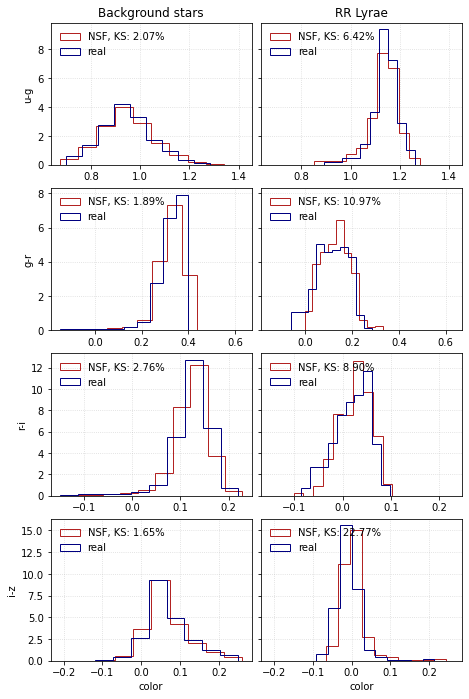

In [39]:
fig, axes = plt.subplots(4, 2, constrained_layout=True, sharex="row", sharey="row", figsize=(6.4, 9.6))
axes= axes.flatten()


for i in range(4):
    ax_stars = axes[2*i]
    ax_rrlyrae = axes[2*i+1]
    
    ks_stars = ks_2samp(smp_stars[:, i], X[:, i][stars])[0]
    ks_rrlyrae = ks_2samp(smp_rrlyrae[:, i], X[:, i][rrlyrae])[0]
    
    ax_stars.hist(smp_stars[:, i], histtype="step", color="firebrick", linestyle="-", label=f"NSF, KS: {ks_stars:.2%}", density=True)
    ax_stars.hist(X[:, i][stars], histtype="step", color="navy", linestyle="-", label="real", density=True)
    
    ax_rrlyrae.hist(smp_rrlyrae[:, i], histtype="step", color="firebrick", linestyle="-", label=f"NSF, KS: {ks_rrlyrae:.2%}", density=True)
    ax_rrlyrae.hist(X[:, i][rrlyrae], histtype="step", color="navy", linestyle="-", label="real", density=True)
    
    ax_stars.set_ylabel(features[i])
    
    ax_stars.legend(loc="upper left", ncol=1, frameon=False)
    ax_rrlyrae.legend(loc="upper left", ncol=1, frameon=False)
    
    ax_stars.grid(ls=":", alpha=.5)
    ax_rrlyrae.grid(ls=":", alpha=.5)

    
axes[0].set_title("Background stars")
axes[1].set_title("RR Lyrae")

axes[-2].set_xlabel("color")
axes[-1].set_xlabel("color")

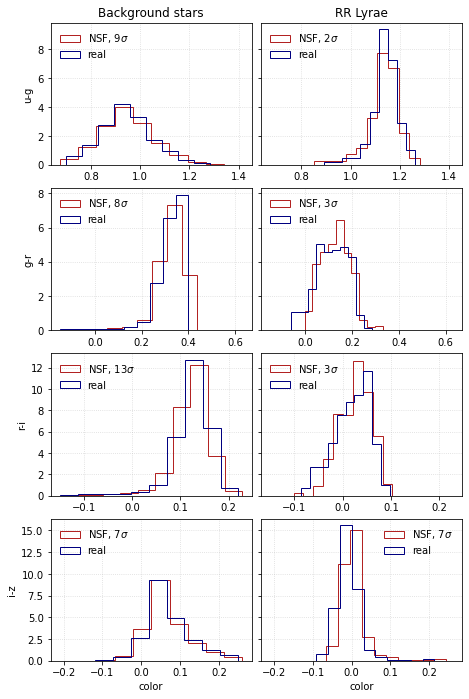

In [40]:
def std_norm(x):
    return np.exp(-x**2 / 2) / (2*np.pi)

x_arr = np.linspace(-1000, 1000, 1000000, dtype=np.float128)
norm_arr = std_norm(x_arr)

tot_arr = norm_arr.sum()

sigmas = [1]
for i in np.arange(50, dtype=np.float128):
    sig_i = i+1
    mask = (x_arr > -sig_i) * (x_arr < sig_i)
    sigmas.append(1 - np.sum(norm_arr[mask]) / tot_arr)
    
def sig_quantile(x):
    for i in range(len(sigmas)-1):
        if x < sigmas[i] and x >= sigmas[i+1]:
            return i+1
    return np.inf

fig, axes = plt.subplots(4, 2, constrained_layout=True, sharex="row", sharey="row", figsize=(6.4, 9.6))
axes= axes.flatten()


for i in range(4):
    ax_stars = axes[2*i]
    ax_rrlyrae = axes[2*i+1]
    
    ks_stars = ks_2samp(smp_stars[:, i], X[:, i][stars])[1]
    ks_rrlyrae = ks_2samp(smp_rrlyrae[:, i], X[:, i][rrlyrae])[1]
    
    sig_stars = sig_quantile(ks_stars)
    sig_rrlyrae = sig_quantile(ks_rrlyrae)
    
    ax_stars.hist(smp_stars[:, i], histtype="step", color="firebrick", linestyle="-", label=r"NSF, %d$\sigma$"%sig_stars, density=True)
    ax_stars.hist(X[:, i][stars], histtype="step", color="navy", linestyle="-", label="real", density=True)
    
    ax_rrlyrae.hist(smp_rrlyrae[:, i], histtype="step", color="firebrick", linestyle="-", label=r"NSF, %d$\sigma$"%sig_rrlyrae, density=True)
    ax_rrlyrae.hist(X[:, i][rrlyrae], histtype="step", color="navy", linestyle="-", label="real", density=True)
    
    ax_stars.set_ylabel(features[i])
    
    ax_stars.legend(loc="upper left", ncol=1, frameon=False)
    if i!=3:
        ax_rrlyrae.legend(loc="upper left", ncol=1, frameon=False)
    else:
        ax_rrlyrae.legend(loc="upper right", ncol=1, frameon=False)
    
    ax_stars.grid(ls=":", alpha=.5)
    ax_rrlyrae.grid(ls=":", alpha=.5)

    
axes[0].set_title("Background stars")
axes[1].set_title("RR Lyrae")

axes[-2].set_xlabel("color")
axes[-1].set_xlabel("color")

plt.savefig("figs/ks_test/man-best-Layers_16.pdf")

Text(0, 0.5, 'g-r')

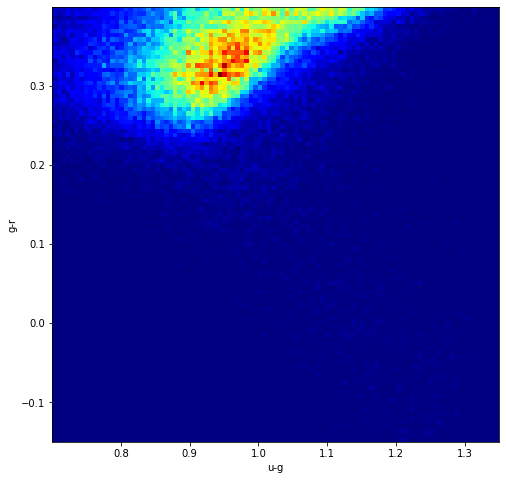

In [41]:
plt.figure(figsize=(8,8))
_ = plt.hist2d(X[:, 0][stars], X[:, 1][stars], bins=100, cmap=plt.cm.jet)
plt.xlabel(features[0])
plt.ylabel(features[1])

Text(0, 0.5, 'g-r')

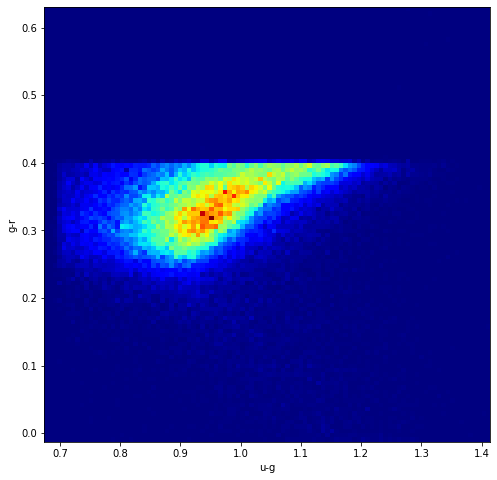

In [42]:
plt.figure(figsize=(8,8))
_ = plt.hist2d(smp_stars[:, 0], smp_stars[:, 1], bins=100, cmap=plt.cm.jet)
plt.xlabel(features[0])
plt.ylabel(features[1])

Text(0, 0.5, 'g-r')

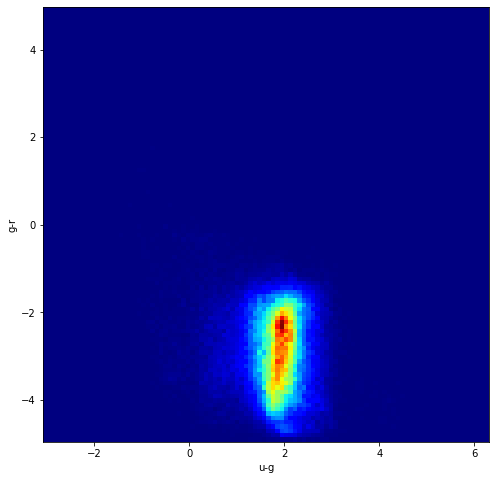

In [43]:
plt_smp = flow_rrlyrae.sample(100000)

plt.figure(figsize=(8,8))
_ = plt.hist2d(plt_smp[:, 0], plt_smp[:, 1], bins=100, cmap=plt.cm.jet)
plt.xlabel(features[0])
plt.ylabel(features[1])